Chargement du 'Master file' financier (INPI)...
Fichier INPI (bilans) chargé: (3706645, 21)
Création du dataset N vs N+1 (2018 vs 2019)...
Dataset de Régression créé. Shape: (414105, 22)
Définition des features (X) et de la target (Y)...
Clipping des outliers (valeurs > 5 et < -5)...
Features (X) sélectionnées: 18 au total
Target (y) sélectionnée: TARGET_rentabilite_N_plus_1
Preprocessing avec ROBUST Scaler...
Création de la pipeline (RobustScaler + XGB Regressor)...
Entraînement du Modèle D (Régression)...
Évaluation du Modèle D...
---
--- RÉSULTATS DU MODÈLE D (ITÉRATION 'RÉGRESSION') ---
Score R-squared (R²) : 0.2873
Mean Absolute Error (MAE) : 2.0186
Root Mean Squared Error (RMSE) : 3.0095
---


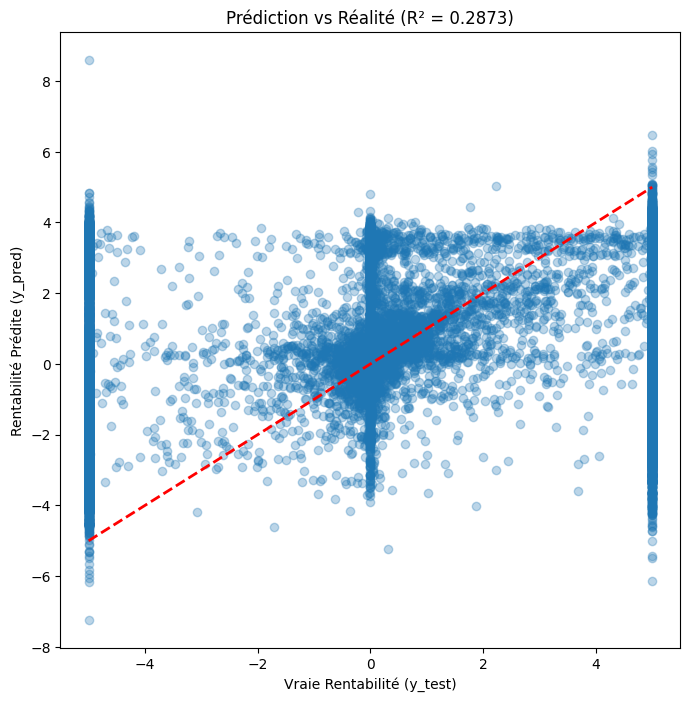

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor # <-- ON IMPORTE LE REGRESSEUR
import matplotlib.pyplot as plt

# --- 1. CHARGER LE "MASTER FILE" FINANCIER ---
print("Chargement du 'Master file' financier (INPI)...")
try:
    df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
    print(f"Fichier INPI (bilans) chargé: {df_bilan.shape}")
except Exception as e:
    print("ERREUR: Fichier 'sirene_bilan.parquet' non trouvé.")
    raise e

# --- 2. CRÉATION DU DATASET (LE "SELF-JOIN" TEMPOREL) ---
print("Création du dataset N vs N+1 (2018 vs 2019)...")

# A. Les FEATURES (X) : Bilans de 2018
df_2018 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2018
)

# B. La TARGET (Y) : Bilans de 2019
df_2019 = df_bilan.filter(
    pl.col("AnneeClotureExercice") == 2019
).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N_plus_1") # La target
)

# C. JOINTURE "INNER"
# On ne garde que les entreprises qui ont un bilan en 2018 ET 2019
df_ml = df_2018.join(
    df_2019, 
    on="siren", 
    how="inner"
)
print(f"Dataset de Régression créé. Shape: {df_ml.shape}")

# --- 3. DÉFINITION DES FEATURES (X) ET TARGET (Y) ---
print("Définition des features (X) et de la target (Y)...")

# FEATURES (X) : Les données brutes ET les ratios de l'année N-1 (2018)
FINANCIAL_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel"
]
TARGET = "TARGET_rentabilite_N_plus_1"

# --- 4. NETTOYAGE DES OUTLIERS (Clipping) ---
# On "clippe" les features ET la target pour enlever le bruit
print("Clipping des outliers (valeurs > 5 et < -5)...")
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0

df_ml = df_ml.with_columns(
    pl.col(FINANCIAL_FEATURES + [TARGET]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion en Pandas
X = df_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {len(FINANCIAL_FEATURES)} au total")
print(f"Target (y) sélectionnée: {y.name}")

# --- 5. PRÉPARATION (Preprocessing) ---
print("Preprocessing avec ROBUST Scaler...")
numerical_transformer = RobustScaler()
preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, FINANCIAL_FEATURES)],
    remainder="passthrough"
)

# --- 6. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 7. CRÉATION DE LA PIPELINE DE RÉGRESSION ---
print("Création de la pipeline (RobustScaler + XGB Regressor)...")
model_D = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor( # <-- C'EST UN REGRESSEUR
        objective='reg:squarederror', # Objectif = minimiser l'erreur
        eval_metric='rmse',
        random_state=42
    ))
])

# --- 8. ENTRAÎNEMENT (Itération "Pivot") ---
print("Entraînement du Modèle D (Régression)...")
model_D.fit(X_train, y_train)

# --- 9. ÉVALUATION (Le Score "Monstrueux") ---
print("Évaluation du Modèle D...")
y_pred = model_D.predict(X_test)

# Scores de Régression
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("---")
print("--- RÉSULTATS DU MODÈLE D (ITÉRATION 'RÉGRESSION') ---")
print(f"Score R-squared (R²) : {r2:.4f}")
print(f"Mean Absolute Error (MAE) : {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse:.4f}")
print("---")

# Plot "Prédiction vs Réalité"
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.xlabel("Vraie Rentabilité (y_test)")
plt.ylabel("Rentabilité Prédite (y_pred)")
plt.title(f"Prédiction vs Réalité (R² = {r2:.4f})")
plt.show()

In [2]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score # <-- On importe KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder # <-- On importe les deux
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1. CHARGER LES "MASTER FILES" (Les deux !) ---
print("Chargement des 2 'Master files'...")
try:
    df_bilan = pl.read_parquet("../Data/processed/sirene_bilan.parquet")
    df_sirene = pl.read_parquet("../Data/processed/sirene_infos.parquet")
    print(f"Fichier INPI (bilans) chargé: {df_bilan.shape}")
    print(f"Fichier SIRENE (infos) chargé: {df_sirene.shape}")
except Exception as e:
    print("ERREUR: Fichiers 'processed' non trouvés.")
    raise e

# --- 2. CRÉATION DU DATASET (LE "SELF-JOIN" TEMPOREL) ---
print("Création du dataset temporel (N-2, N-1 -> N)...")

# A. Features de N-2 (2017)
df_2017 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2017).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("rentabilite_N_moins_2"),
    pl.col("FA_ChiffreAffairesVentes").alias("CA_N_moins_2")
)

# B. Features de N-1 (2018)
df_2018 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2018)

# C. Target de N (2019)
df_2019 = df_bilan.filter(pl.col("AnneeClotureExercice") == 2019).select(
    "siren",
    pl.col("ratio_rentabilite_nette").alias("TARGET_rentabilite_N")
)

# --- 3. LE FEATURE ENGINEERING "MONSTRUEUX" ---
print("Création des features de 'Vélocité' (Variation)...")

# On joint 2018 (N-1) avec 2017 (N-2)
df_features = df_2018.join(df_2017, on="siren", how="left").with_columns(
    # Feature de "Vélocité" (la variation de rentabilité)
    (pl.col("ratio_rentabilite_nette") - pl.col("rentabilite_N_moins_2")).fill_null(0).alias("variation_rentabilite"),
    # Feature de "Croissance CA"
    (pl.col("FA_ChiffreAffairesVentes") - pl.col("CA_N_moins_2")).fill_null(0).alias("variation_CA")
)

# On joint avec les features "Démo" (le châssis !)
df_features = df_features.join(
    df_sirene.select("siren", "categorieJuridiqueUniteLegale", "departement"),
    on="siren",
    how="left"
)

# --- 4. JOINTURE FINALE (Features + Target) ---
df_ml = df_features.join(
    df_2019, 
    on="siren", 
    how="inner" # INNER JOIN : on ne garde que les boîtes qui existent sur les 3 ans
)
print(f"Dataset de Régression 'Monstre' créé. Shape: {df_ml.shape}")

# --- 5. DÉFINITION DES FEATURES (X) ET TARGET (Y) ---
print("Définition des features (X) et de la target (Y)...")

# Features Numériques (Financières)
NUMERIC_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel",
    # LES NOUVELLES FEATURES "MONSTRUEUSES"
    "variation_rentabilite",
    "variation_CA"
]

# Features Catégorielles (Démo)
CATEGORICAL_FEATURES = [
    "categorieJuridiqueUniteLegale", 
    "departement"
]

TARGET = "TARGET_rentabilite_N"

# --- 6. NETTOYAGE DES OUTLIERS (Clipping) ---
print("Clipping des outliers (valeurs > 5 et < -5)...")
LOWER_BOUND = -5.0
UPPER_BOUND = 5.0

# On clippe les ratios ET la target
df_ml = df_ml.with_columns(
    pl.col([c for c in df_ml.columns if "ratio" in c or "TARGET" in c]).clip(
        lower_bound=LOWER_BOUND, upper_bound=UPPER_BOUND
    )
).fill_null(0) # Nettoyage final

# Conversion en Pandas
X = df_ml.select(NUMERIC_FEATURES + CATEGORICAL_FEATURES).to_pandas()
y = df_ml.select(TARGET).to_pandas().squeeze()

# --- 7. PRÉPARATION (Le Preprocessor "Monstre") ---
print("Preprocessing avec RobustScaler (Num) + OHE (Cat)...")
numerical_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# --- 8. CRÉATION DE LA PIPELINE DE RÉGRESSION ---
print("Création de la pipeline (Preprocessor + XGB Regressor)...")
model_E = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    ))
])

# --- 9. ENTRAÎNEMENT & ÉVALUATION (AVEC CROSS-VALIDATION) ---
print("Lancement de la K-Fold Cross-Validation (k=5)...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# On score sur le R²
scores_r2 = cross_val_score(model_E, X, y, cv=kfold, scoring='r2')
# On score sur l'erreur absolue
scores_mae = cross_val_score(model_E, X, y, cv=kfold, scoring='neg_mean_absolute_error')

print("---")
print("--- RÉSULTATS DU MODÈLE E (ITÉRATION 'VÉLOCITÉ') ---")
print(f"Scores R-squared (R²) des 5 'Folds': {np.round(scores_r2, 4)}")
print(f"Score R² MOYEN (Cross-Val) : {np.mean(scores_r2):.4f} (+/- {np.std(scores_r2):.4f})")
print("---")
print(f"Scores MAE (négatifs) des 5 'Folds': {np.round(scores_mae, 4)}")
print(f"Score MAE MOYEN (Cross-Val) : {-np.mean(scores_mae):.4f}")
print("---")

Chargement des 2 'Master files'...
Fichier INPI (bilans) chargé: (3706645, 21)
Fichier SIRENE (infos) chargé: (28882409, 7)
Création du dataset temporel (N-2, N-1 -> N)...
Création des features de 'Vélocité' (Variation)...
Dataset de Régression 'Monstre' créé. Shape: (415027, 28)
Définition des features (X) et de la target (Y)...
Clipping des outliers (valeurs > 5 et < -5)...
Preprocessing avec RobustScaler (Num) + OHE (Cat)...
Création de la pipeline (Preprocessor + XGB Regressor)...
Lancement de la K-Fold Cross-Validation (k=5)...
---
--- RÉSULTATS DU MODÈLE E (ITÉRATION 'VÉLOCITÉ') ---
Scores R-squared (R²) des 5 'Folds': [0.3128 0.3219 0.3194 0.3178 0.3197]
Score R² MOYEN (Cross-Val) : 0.3183 (+/- 0.0031)
---
Scores MAE (négatifs) des 5 'Folds': [-1.9477 -1.9332 -1.9327 -1.954  -1.9252]
Score MAE MOYEN (Cross-Val) : 1.9386
---
